In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import random
from osgeo import gdal
import os
import os.path
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import math
import warnings
warnings.filterwarnings("ignore")

**Thử chạy RF regression với dataset gồm các features:**

$BT10.4$

$\Delta T7.3-13.3$

$\Delta T8.6-10.4$

$\Delta T10.4-12.4$

$\Delta T6.2-6.9$

$\Delta T6.9-7.3$

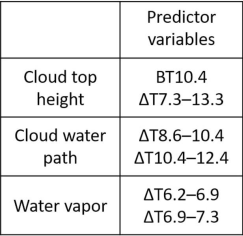

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Rainfall Data/Tablet/Dataset.csv')

**1. Điều chỉnh bộ dữ liệu cho cân bằng**

In [ ]:
clus_dat = df.copy()
clus_dat['rain'] = (clus_dat['Giá trị'] > 0).astype(int)
df_balance = pd.concat((clus_dat[clus_dat['rain'] == 1], clus_dat[clus_dat['rain'] == 0].head(516)))

**2. Phân loại mưa - không mưa**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_balance[['10.4', '7.3-13.3', '8.6-10.4', '10.4-12.4', '6.2-6.9', '6.9-7.3']], df_balance['rain'], test_size= 0.25, random_state=42)
rfc = RandomForestClassifier(n_estimators=8, random_state=42).fit(X_train, y_train)

In [ ]:
print(classification_report(y_train, rfc.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       389
           1       0.99      0.93      0.96       191

    accuracy                           0.97       580
   macro avg       0.98      0.96      0.97       580
weighted avg       0.97      0.97      0.97       580



In [ ]:
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.87      0.80       127
           1       0.62      0.39      0.48        67

    accuracy                           0.71       194
   macro avg       0.67      0.63      0.64       194
weighted avg       0.69      0.71      0.69       194



In [ ]:
print(classification_report(clus_dat['rain'], rfc.predict(clus_dat[['10.4', '7.3-13.3', '8.6-10.4', '10.4-12.4', '6.2-6.9', '6.9-7.3']])))

              precision    recall  f1-score   support

           0       0.97      0.69      0.80      2303
           1       0.22      0.79      0.34       258

    accuracy                           0.70      2561
   macro avg       0.59      0.74      0.57      2561
weighted avg       0.89      0.70      0.76      2561



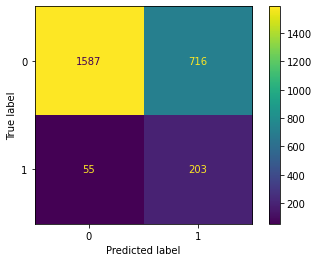

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(clus_dat['rain'], rfc.predict(clus_dat[['10.4', '7.3-13.3', '8.6-10.4', '10.4-12.4', '6.2-6.9', '6.9-7.3']]))).plot()

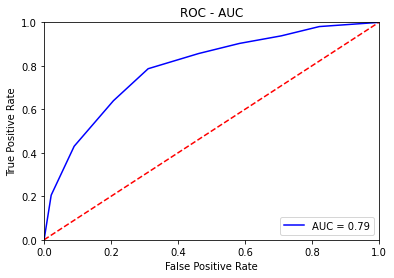

In [ ]:
fpr, tpr, threshold = roc_curve(clus_dat['rain'], rfc.predict_proba(clus_dat[['10.4', '7.3-13.3', '8.6-10.4', '10.4-12.4', '6.2-6.9', '6.9-7.3']])[:, 1])
roc_auc = auc(fpr, tpr)
plt.title('ROC - AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

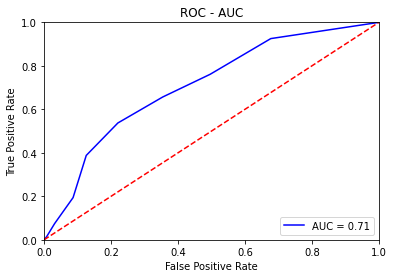

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, rfc.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.title('ROC - AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**3. Dự đoán mưa trên những điểm dữ liệu đã detect rain**

In [ ]:
dt_est = df.copy()
dt_est['pred_rain'] = rfc.predict(dt_est[['10.4', '7.3-13.3', '8.6-10.4', '10.4-12.4', '6.2-6.9', '6.9-7.3']])
dts_est = dt_est[dt_est['pred_rain'] == 1][['10.4', '7.3-13.3', '8.6-10.4', '10.4-12.4', '6.2-6.9', '6.9-7.3', 'Giá trị']]
X_trn, X_tst, y_trn, y_tst = train_test_split(dts_est.drop(columns=['Giá trị']), dts_est['Giá trị'], random_state=42)
rfe = RandomForestRegressor(n_estimators = 8, random_state=42).fit(X_trn, y_trn)

In [ ]:
print('MSE train: %.2f' % mean_squared_error(y_trn, rfe.predict(X_trn)))
print('MSE test: %.2f' % mean_squared_error(y_tst, rfe.predict(X_tst)))

MSE train: 0.18
MSE test: 1.71


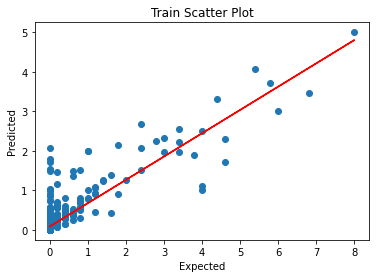

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Train Scatter Plot')
plt.plot(y_trn, rfe.predict(X_trn), 'o')
m, b = np.polyfit(y_trn, rfe.predict(X_trn), 1)
plt.plot(y_trn, m*y_trn + b, 'r')
plt.show()

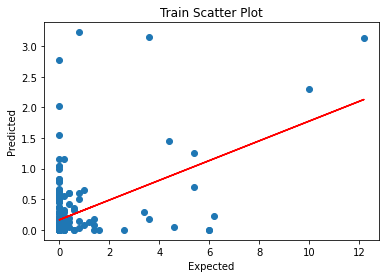

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Train Scatter Plot')
plt.plot(y_tst, rfe.predict(X_tst), 'o')
m, b = np.polyfit(y_tst, rfe.predict(X_tst), 1)
plt.plot(y_tst, m*y_tst + b, 'r')
plt.show()

**4. Chạy toàn bộ quy trình trên toàn bộ tập dữ liệu**

In [ ]:
for i in range(len(df.columns)):
    if df.columns[i] == '10.4':
        print('10.4 -- ', i)
    if df.columns[i] == '7.3-13.3':
        print('7.3-13.3 -- ', i)
    if df.columns[i] == '8.6-10.4':
        print('8.6-10.4 -- ', i)
    if df.columns[i] == '10.4-12.4':
        print('10.4-12.4 -- ', i)
    if df.columns[i] == '6.2-6.9':
        print('6.2-6.9 -- ', i)
    if df.columns[i] == '6.9-7.3':
        print('6.9-7.3 -- ', i)

10.4 --  6
6.2-6.9 --  10
6.9-7.3 --  12
8.6-10.4 --  23
10.4-12.4 --  36
7.3-13.3 --  40


In [ ]:
# [['10.4', '7.3-13.3', '8.6-10.4', '10.4-12.4', '6.2-6.9', '6.9-7.3']]
res = np.zeros(len(df))
for i in range(len(df)):
    if rfc.predict([[df.iloc[i, 6], df.iloc[i, 40], df.iloc[i, 23], df.iloc[i, 36], df.iloc[i, 10], df.iloc[i, 12]]])[0] == 0:
        continue
    res[i] = rfe.predict([[df.iloc[i, 6], df.iloc[i, 40], df.iloc[i, 23], df.iloc[i, 36], df.iloc[i, 10], df.iloc[i, 12]]])[0]

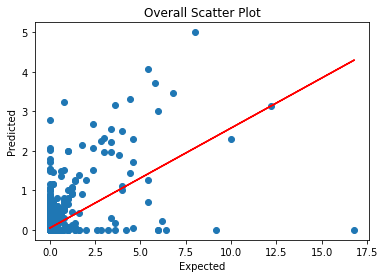

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Overall Scatter Plot')
plt.plot(df['Giá trị'], res, 'o')
m, b = np.polyfit(df['Giá trị'], res, 1)
plt.plot(df['Giá trị'], m*df['Giá trị'] + b, 'r')
plt.show()

In [ ]:
df['Giá trị'].corr(pd.Series(res))

0.5643700821321301

In [ ]:
print('MSE Overall: %.2f' % mean_squared_error(df['Giá trị'], res))
print('mean of observed: %.2f' % np.mean(df['Giá trị']))
print('mean of estimate: %.2f' % np.mean(res))
print('varience of observed: %.2f' % np.var(df['Giá trị']))
print('varience of estimate: %.2f' % np.var(res))
print('std of observed: %.2f' % np.std(df['Giá trị']))
print('std of estimate: %.2f' % np.std(res))

MSE Overall: 0.39
mean of observed: 0.12
mean of estimate: 0.08
varience of observed: 0.55
varience of estimate: 0.11
std of observed: 0.74
std of estimate: 0.33


**5. Dựng bản đồ lượng mưa**

In [ ]:
def Rain_estimate(day, hour, minute):
    # check if file exist or not
    if os.path.isfile('/content/drive/My Drive/Rainfall Data/Raster/rainrate_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tif'):
        return
    # 6.2
    if os.path.isfile('/content/drive/My Drive/Rainfall Data/Tiff/tbb_08/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_08_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff') == False:    return
    m62 = gdal.Open('/content/drive/My Drive/Rainfall Data/Tiff/tbb_08/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_08_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff')
    if m62 is None: return
    m62b = m62.GetRasterBand(1)
    gt = m62.GetGeoTransform()
    prj = m62.GetProjection()
    m62a = m62b.ReadAsArray().astype(np.float64)
    m62a[m62a == 0] = np.nan

    # 7.3
    if os.path.isfile('/content/drive/My Drive/Rainfall Data/Tiff/tbb_10/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_10_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff') == False:    return
    m73 = gdal.Open('/content/drive/My Drive/Rainfall Data/Tiff/tbb_10/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_10_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff')
    if m73 is None: return
    m73b = m73.GetRasterBand(1)
    m73a = m73b.ReadAsArray().astype(np.float64)
    m73a[m73a == 0] = np.nan

    # 13.3
    if os.path.isfile('/content/drive/My Drive/Rainfall Data/Tiff/tbb_16/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_16_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff') == False:    return
    m133 = gdal.Open('/content/drive/My Drive/Rainfall Data/Tiff/tbb_16/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_16_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff')
    if m133 is None: return
    m133b = m133.GetRasterBand(1)
    m133a = m133b.ReadAsArray().astype(np.float64)
    m133a[m133a == 0] = np.nan

    # 8.6
    if os.path.isfile('/content/drive/My Drive/Rainfall Data/Tiff/tbb_11/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_11_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff') == False:    return
    m86 = gdal.Open('/content/drive/My Drive/Rainfall Data/Tiff/tbb_11/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_11_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff')
    if m86 is None: return
    m86b = m86.GetRasterBand(1)
    m86a = m86b.ReadAsArray().astype(np.float64)
    m86a[m86a == 0] = np.nan

    # 12.4
    if os.path.isfile('/content/drive/My Drive/Rainfall Data/Tiff/tbb_15/' + str(day).rjust(2, '0')\
                      + '/H08_tbb_15_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff') == False:   return
    m124 = gdal.Open('/content/drive/My Drive/Rainfall Data/Tiff/tbb_15/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_15_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff')
    if m124 is None: return
    m124b = m124.GetRasterBand(1)
    m124a = m124b.ReadAsArray().astype(np.float64)
    m124a[m124a == 0] = np.nan

    # 6.9
    if os.path.isfile('/content/drive/My Drive/Rainfall Data/Tiff/tbb_09/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_09_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff') == False:    return
    m69 = gdal.Open('/content/drive/My Drive/Rainfall Data/Tiff/tbb_09/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_09_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff')
    if m69 is None: return
    m69b = m69.GetRasterBand(1)
    m69a = m69b.ReadAsArray().astype(np.float64)
    m69a[m69a == 0] = np.nan

    # 10.4
    if os.path.isfile('/content/drive/My Drive/Rainfall Data/Tiff/tbb_13/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_13_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff') == False:   return
    m104 = gdal.Open('/content/drive/My Drive/Rainfall Data/Tiff/tbb_13/' + str(day).rjust(2, '0')\
                    + '/H08_tbb_13_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tiff')
    if m104 is None: return
    m104b = m104.GetRasterBand(1)
    m104a = m104b.ReadAsArray().astype(np.float64)
    m104a[m104a == 0] = np.nan

    # fill into result an array
    res_array = np.empty_like(m62a)
    res_array[:] = np.nan

    # Using models rfc and rfe to predict the rain rate
    for i in range(m62a.shape[0]):
        for j in range(m62a.shape[1]):
            if math.isnan(m69a[i][j]) or math.isnan(m62a[i][j]) or math.isnan(m73a[i][j]) or math.isnan(m86a[i][j]) or math.isnan(m104a[i][j]) or math.isnan(m124a[i][j]) or math.isnan(m133a[i][j]):
                continue
            # ignore the no data
            res_array[i][j] = 0
            if rfc.predict([[m104a[i][j], m73a[i][j] - m133a[i][j], m86a[i][j] - m104a[i][j], m104a[i][j] - m124a[i][j], m62a[i][j] - m69a[i][j], m69a[i][j] - m73a[i][j]]])[0] == 0:
                continue
            # ignore the not rain pixel
            res_array[i][j] = rfe.predict([[m104a[i][j], m73a[i][j] - m133a[i][j], m86a[i][j] - m104a[i][j], m104a[i][j] - m124a[i][j], m62a[i][j] - m69a[i][j], m69a[i][j] - m73a[i][j]]])[0]

    # Generate a raster map
    driver = gdal.GetDriverByName('Gtiff')
    dataset = driver.Create('/content/drive/My Drive/Rainfall Data/Raster/rainrate_201908' + str(day).rjust(2, '0') + '_' + str(hour).rjust(2, '0') + str(minute).rjust(2, '0') + '.tif'\
                            , m62a.shape[1], m62a.shape[0], 1, gdal.GDT_Float64)
    dataset.SetGeoTransform(gt)
    dataset.SetProjection(prj)
    b = dataset.GetRasterBand(1)
    b.SetNoDataValue(-99999)
    b.Fill(-99999, 0.0)
    b.WriteArray(res_array)
    dataset = None

*Chạy lập bản đồ lượng mưa với tất cả dữ liệu ngày*

In [ ]:
# run estimate with all days
for day in range(1, 32):
    for hour in range(0, 24):
        for minute in range(0, 51):
            Rain_estimate(day, hour, minute)